# NOTEBOOK 02 : ANALYSE STATISTIQUE APPROFONDIE
**Projet** : REG09 - Prévision des ventes (item_nbr)

**Objectif** : Analyse univariée, bivariée et multivariée sur échantillon représentatif

**Données** : Échantillon HYBRID (20% stores × 365 jours récents) ≈ 5M lignes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from data_sampler import SalesDataSampler, optimize_dtypes

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

## 1. CHARGEMENT DES DONNÉES

In [2]:
# Charger fichiers auxiliaires


items = pd.read_csv('data/items.csv')
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])

# Créer échantillon HYBRID (20% stores × 365 jours récents)
print("Création de l'échantillon...")
train_full = pd.read_csv('data/train.csv', parse_dates=['date'])
sampler = SalesDataSampler(train_full, items)
train = sampler.hybrid_sample(store_frac=0.2, recent_days=365, random_state=42)
train = optimize_dtypes(train)

# Comparer avec original
sampler.compare_samples(train)

# Sauvegarder pour réutilisation
sampler.save_sample(train, 'hybrid_20pct_365d')

# Libérer mémoire
del train_full, sampler

Création de l'échantillon...
Dataset chargé: 125,497,040 lignes
Période: 2013-01-01 → 2017-08-15 (1688 jours)
Magasins: 54, Items: 4036

[HYBRID SAMPLING] 20% magasins × 365 derniers jours
Magasins: 10/54
Période: 2016-08-15 → 2017-08-15
Résultat: 6,980,883 lignes (5.56%)

COMPARAISON ÉCHANTILLON vs DONNÉES ORIGINALES

Taille:
  Original: 125,497,040 lignes
  Échantillon: 6,980,883 lignes (5.56%)

Magasins:
  Original: 54
  Échantillon: 10 (18.5%)

Items:
  Original: 4036
  Échantillon: 4016 (99.5%)

Période:
  Original: 2013-01-01 → 2017-08-15 (1688 jours)
  Échantillon: 2016-08-15 → 2017-08-15 (366 jours)

Ventes (unit_sales):
  Original - Moyenne: 8.55, Médiane: 4.00
  Échantillon - Moyenne: 7.92, Médiane: 4.00

✓ Échantillon sauvegardé: data/samples/train_sample_hybrid_20pct_365d_20260214_233500.csv
  Taille: 6,980,883 lignes


In [3]:
# Merger avec métadonnées
train = train.merge(items[['item_nbr', 'family', 'class', 'perishable']], on='item_nbr', how='left')
train = train.merge(stores[['store_nbr', 'city', 'state', 'type', 'cluster']], on='store_nbr', how='left')

print(f"Shape finale: {train.shape}")
print(f"\nMémoire: {train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nPériode: {train['date'].min()} à {train['date'].max()}")

Shape finale: (6980883, 13)

Mémoire: 1786.7 MB

Période: 2016-08-15 00:00:00 à 2017-08-15 00:00:00


## 2. ANALYSE UNIVARIÉE

In [4]:
# Statistiques descriptives UNIT_SALES
print("=" * 60)
print("STATISTIQUES UNIT_SALES")
print("=" * 60)
print(train['unit_sales'].describe())

# Distribution par signe
sales_pos = train[train['unit_sales'] > 0]['unit_sales']
sales_neg = train[train['unit_sales'] < 0]['unit_sales']
sales_zero = train[train['unit_sales'] == 0]['unit_sales']

print(f"\nPositives : {len(sales_pos):,} ({len(sales_pos)/len(train)*100:.2f}%)")
print(f"Nulles    : {len(sales_zero):,} ({len(sales_zero)/len(train)*100:.2f}%)")
print(f"Négatives : {len(sales_neg):,} ({len(sales_neg)/len(train)*100:.2f}%)")

print(f"\nSkewness : {train['unit_sales'].skew():.2f}")
print(f"Kurtosis : {train['unit_sales'].kurtosis():.2f}")

STATISTIQUES UNIT_SALES
count    6.980883e+06
mean     7.916429e+00
std      2.224768e+01
min     -3.451363e+03
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.153300e+04
Name: unit_sales, dtype: float64

Positives : 6,980,448 (99.99%)
Nulles    : 0 (0.00%)
Négatives : 435 (0.01%)

Skewness : 94.79
Kurtosis : 31703.93


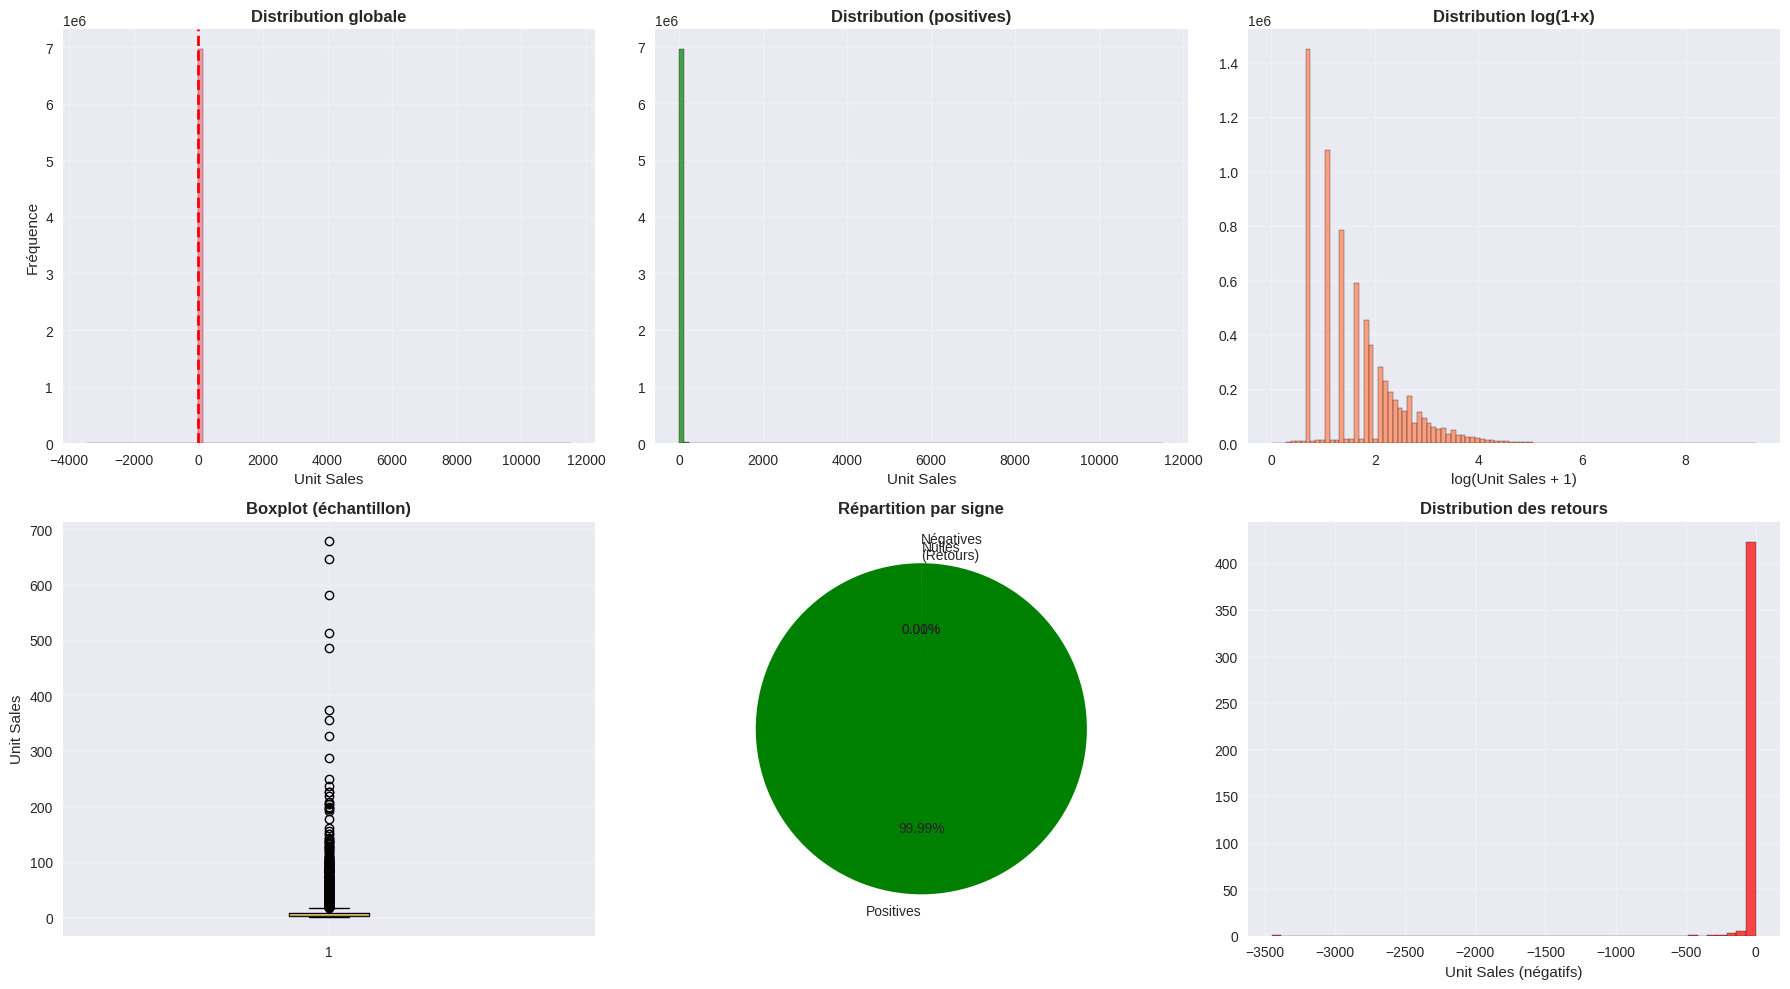

In [5]:
# Visualisations UNIT_SALES
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Histogramme global
axes[0,0].hist(train['unit_sales'], bins=100, edgecolor='black', alpha=0.7)
axes[0,0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0,0].set_title('Distribution globale', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Unit Sales')
axes[0,0].set_ylabel('Fréquence')
axes[0,0].grid(alpha=0.3)

# Histogramme positives
axes[0,1].hist(sales_pos, bins=100, edgecolor='black', alpha=0.7, color='green')
axes[0,1].set_title('Distribution (positives)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Unit Sales')
axes[0,1].grid(alpha=0.3)

# Log transformation
axes[0,2].hist(np.log1p(sales_pos), bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[0,2].set_title('Distribution log(1+x)', fontsize=12, fontweight='bold')
axes[0,2].set_xlabel('log(Unit Sales + 1)')
axes[0,2].grid(alpha=0.3)

# Boxplot
sample_size = min(10000, len(sales_pos))
axes[1,0].boxplot(sales_pos.sample(sample_size))
axes[1,0].set_title('Boxplot (échantillon)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Unit Sales')
axes[1,0].grid(alpha=0.3)

# Pie chart par signe
counts = [len(sales_pos), len(sales_zero), len(sales_neg)]
labels = ['Positives', 'Nulles', 'Négatives\n(Retours)']
colors = ['green', 'gray', 'red']
axes[1,1].pie(counts, labels=labels, autopct='%1.2f%%', colors=colors, startangle=90)
axes[1,1].set_title('Répartition par signe', fontsize=12, fontweight='bold')

# Distribution retours
if len(sales_neg) > 0:
    axes[1,2].hist(sales_neg, bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[1,2].set_title('Distribution des retours', fontsize=12, fontweight='bold')
    axes[1,2].set_xlabel('Unit Sales (négatifs)')
    axes[1,2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/02_univariate_unit_sales.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Statistiques ONPROMOTION
print("=" * 60)
print("STATISTIQUES ONPROMOTION")
print("=" * 60)

nan_count = train['onpromotion'].isnull().sum()
print(f"Valeurs manquantes : {nan_count:,} ({nan_count/len(train)*100:.2f}%)")
print(f"\nDistribution:\n{train['onpromotion'].value_counts(dropna=False)}")

# Ventes moyennes par statut promo
promo_sales = train.groupby('onpromotion', dropna=False)['unit_sales'].agg(['mean', 'median', 'count'])
print(f"\nVentes par statut promo:\n{promo_sales}")

STATISTIQUES ONPROMOTION
Valeurs manquantes : 0 (0.00%)

Distribution:
onpromotion
False    6126091
True      854792
Name: count, dtype: int64

Ventes par statut promo:
                  mean  median    count
onpromotion                            
False         7.249530     3.0  6126091
True         12.695935     5.0   854792


In [7]:
# Analyse temporelle
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['dayofweek'] = train['date'].dt.dayofweek
train['quarter'] = train['date'].dt.quarter

print("=" * 60)
print("ANALYSE TEMPORELLE")
print("=" * 60)
print(f"Période : {train['date'].min()} à {train['date'].max()}")
print(f"Nombre de jours : {train['date'].nunique()}")

# Ventes par année
yearly = train.groupby('year')['unit_sales'].agg(['sum', 'mean'])
print(f"\nVentes par année:\n{yearly}")

ANALYSE TEMPORELLE
Période : 2016-08-15 00:00:00 à 2017-08-15 00:00:00
Nombre de jours : 364

Ventes par année:
             sum      mean
year                      
2016  20671328.0  7.973228
2017  34592336.0  7.882872


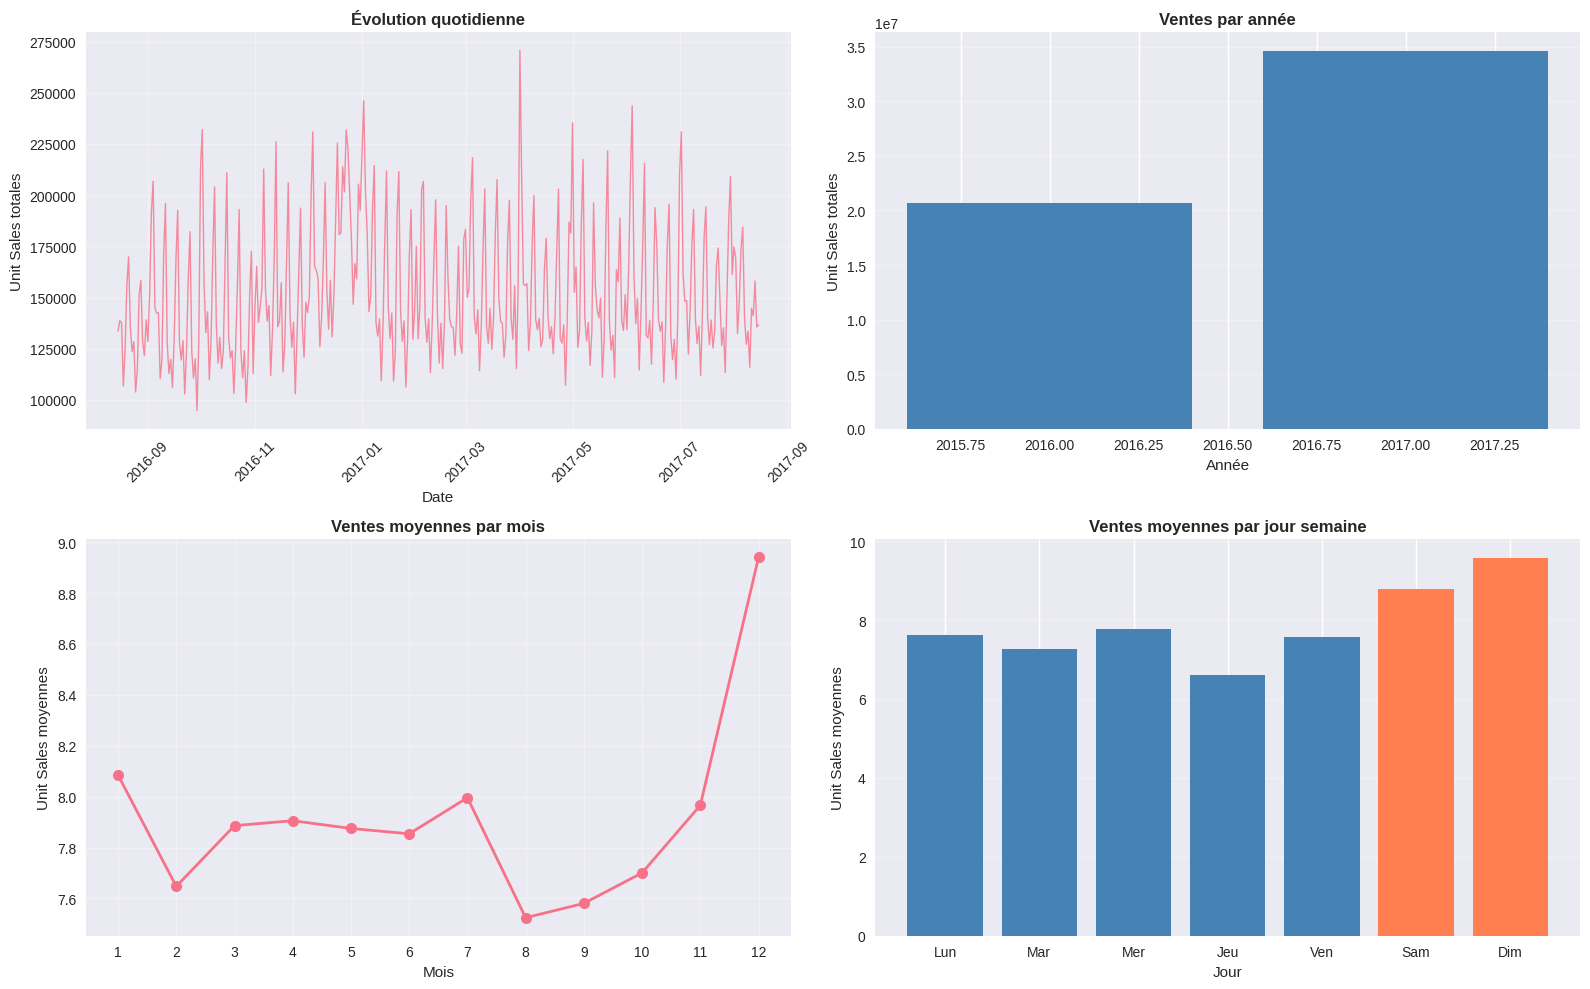

In [8]:
# Visualisations temporelles
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Évolution quotidienne
daily = train.groupby('date')['unit_sales'].sum()
axes[0,0].plot(daily.index, daily.values, linewidth=1, alpha=0.8)
axes[0,0].set_title('Évolution quotidienne', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Unit Sales totales')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(alpha=0.3)

# Par année
axes[0,1].bar(yearly.index, yearly['sum'].values, color='steelblue')
axes[0,1].set_title('Ventes par année', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Année')
axes[0,1].set_ylabel('Unit Sales totales')
axes[0,1].grid(alpha=0.3, axis='y')

# Par mois
monthly = train.groupby('month')['unit_sales'].mean()
axes[1,0].plot(monthly.index, monthly.values, marker='o', linewidth=2, markersize=8)
axes[1,0].set_title('Ventes moyennes par mois', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Mois')
axes[1,0].set_ylabel('Unit Sales moyennes')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].grid(alpha=0.3)

# Par jour semaine
weekday = train.groupby('dayofweek')['unit_sales'].mean()
jours = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
colors = ['coral' if i >= 5 else 'steelblue' for i in range(7)]
axes[1,1].bar(range(7), weekday.values, color=colors)
axes[1,1].set_title('Ventes moyennes par jour semaine', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Jour')
axes[1,1].set_ylabel('Unit Sales moyennes')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(jours)
axes[1,1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/02_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. ANALYSE BIVARIÉE : VENTES vs PROMOTIONS

In [13]:
# Test statistique : impact des promotions
train_clean = train[train['onpromotion'].notna()].copy()

sales_no_promo = train_clean[train_clean['onpromotion'] == False]['unit_sales']
sales_with_promo = train_clean[train_clean['onpromotion'] == True]['unit_sales']

print("=" * 60)
print("IMPACT DES PROMOTIONS")
print("=" * 60)

promo_stats = train_clean.groupby('onpromotion')['unit_sales'].agg(['mean', 'median', 'std', 'count'])
print(promo_stats)

# Test t de Student
if len(sales_no_promo) > 0 and len(sales_with_promo) > 0:
    t_stat, p_value = stats.ttest_ind(sales_no_promo, sales_with_promo)
    print(f"\nTest t de Student :")
    print(f"  t-statistic : {t_stat:.4f}")
    print(f"  p-value : {p_value:.4e}")
    
    if p_value < 0.05:
        print("  Différence SIGNIFICATIVE (p < 0.05)")
        increase = (sales_with_promo.mean() - sales_no_promo.mean()) / sales_no_promo.mean() * 100
        print(f"  Augmentation moyenne : {increase:.1f}%")

IMPACT DES PROMOTIONS
                  mean  median        std    count
onpromotion                                       
False         7.249530     3.0  16.924919  6126091
True         12.695935     5.0  44.308544   854792

Test t de Student :
  t-statistic : -212.7134
  p-value : 0.0000e+00
  Différence SIGNIFICATIVE (p < 0.05)
  Augmentation moyenne : 75.1%


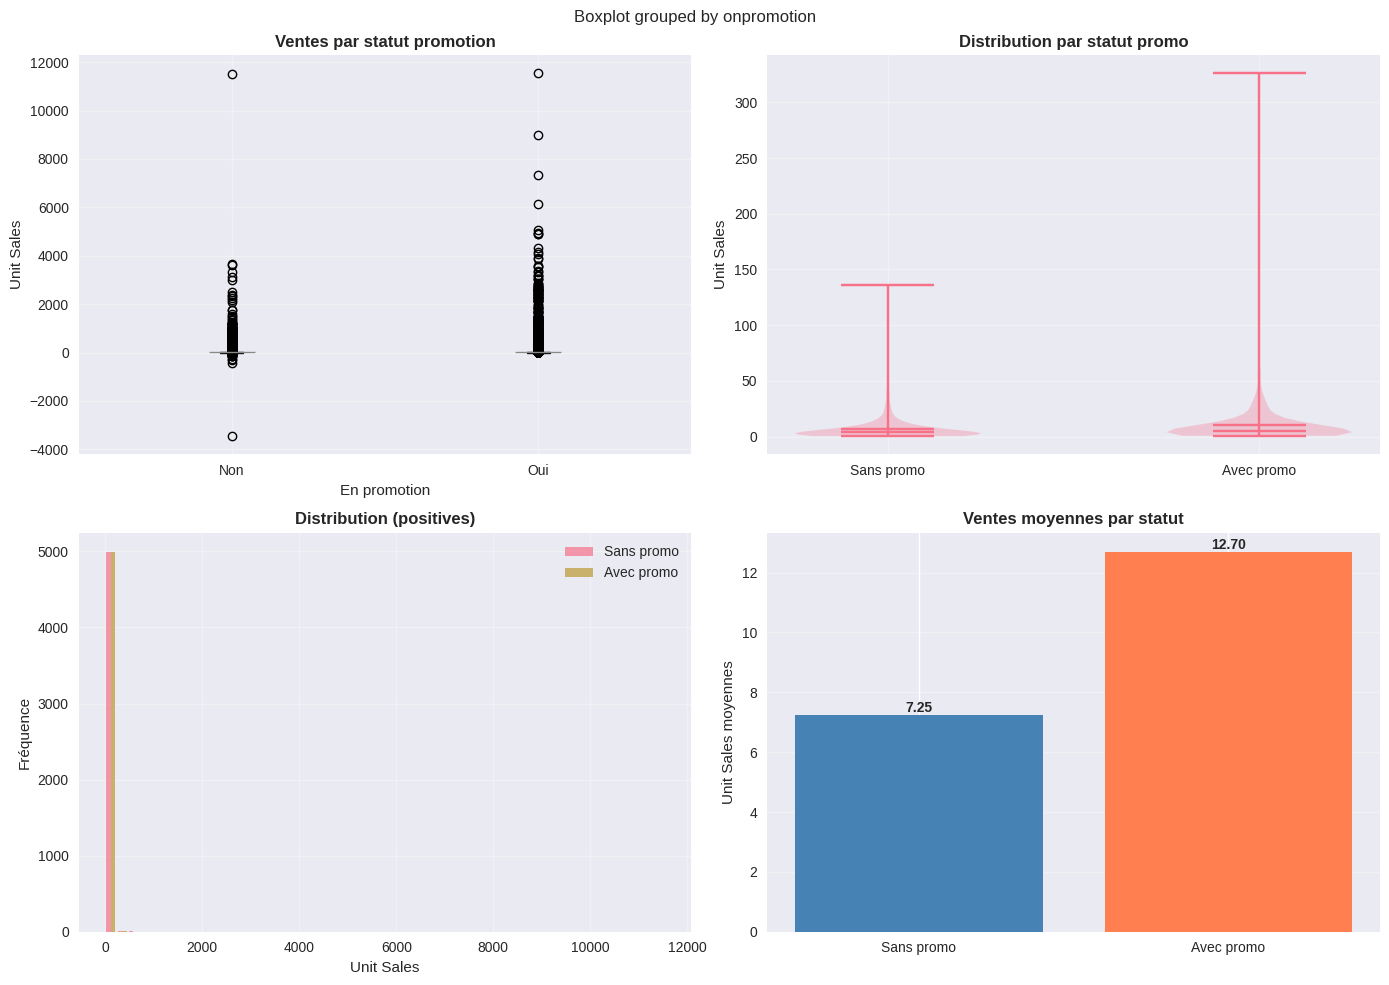

In [14]:
# Visualisations bivariées
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot comparatif
train_clean.boxplot(column='unit_sales', by='onpromotion', ax=axes[0,0])
axes[0,0].set_title('Ventes par statut promotion', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('En promotion')
axes[0,0].set_ylabel('Unit Sales')
axes[0,0].set_xticklabels(['Non', 'Oui'])
axes[0,0].grid(alpha=0.3)
plt.sca(axes[0,0])
plt.xticks([1, 2], ['Non', 'Oui'])

# Violin plot
sample_size = 1000
parts = axes[0,1].violinplot(
    [sales_no_promo.sample(min(sample_size, len(sales_no_promo))),
     sales_with_promo.sample(min(sample_size, len(sales_with_promo)))],
    positions=[0, 1], showmeans=True, showmedians=True
)
axes[0,1].set_title('Distribution par statut promo', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Unit Sales')
axes[0,1].set_xticks([0, 1])
axes[0,1].set_xticklabels(['Sans promo', 'Avec promo'])
axes[0,1].grid(alpha=0.3)

# Histogramme comparatif (positives)
sales_no_promo_pos = sales_no_promo[sales_no_promo > 0]
sales_with_promo_pos = sales_with_promo[sales_with_promo > 0]
axes[1,0].hist([sales_no_promo_pos.sample(min(5000, len(sales_no_promo_pos))),
                sales_with_promo_pos.sample(min(5000, len(sales_with_promo_pos)))],
               bins=50, label=['Sans promo', 'Avec promo'], alpha=0.7)
axes[1,0].set_title('Distribution (positives)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Unit Sales')
axes[1,0].set_ylabel('Fréquence')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Barplot moyennes
means = [sales_no_promo.mean(), sales_with_promo.mean()]
axes[1,1].bar(['Sans promo', 'Avec promo'], means, color=['steelblue', 'coral'])
axes[1,1].set_title('Ventes moyennes par statut', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Unit Sales moyennes')
axes[1,1].grid(alpha=0.3, axis='y')
# Ajouter valeurs sur barres
for i, v in enumerate(means):
    axes[1,1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/02_bivariate_promo.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. ANALYSE MULTIVARIÉE : CORRÉLATIONS

In [16]:
# Matrice de corrélation
numerical_cols = ['unit_sales', 'onpromotion', 'store_nbr', 'item_nbr', 
                  'year', 'month', 'dayofweek', 'quarter', 'perishable']
numerical_cols = [c for c in numerical_cols if c in train.columns]

corr_data = train[numerical_cols].copy()
# Convertir directement en int (pas de NaN selon les stats)
corr_data['onpromotion'] = corr_data['onpromotion'].astype(int)
corr_matrix = corr_data.corr()

print("=" * 60)
print("MATRICE DE CORRÉLATION")
print("=" * 60)
print(corr_matrix)

# Corrélations avec la cible
target_corr = corr_matrix['unit_sales'].sort_values(ascending=False)
print(f"\nCorrélations avec UNIT_SALES:\n{target_corr}")

MATRICE DE CORRÉLATION
             unit_sales  onpromotion  store_nbr  item_nbr      year     month  \
unit_sales     1.000000     0.080248  -0.016391  0.019544 -0.001962  0.004638   
onpromotion    0.080248     1.000000  -0.001077  0.012423 -0.021840  0.033991   
store_nbr     -0.016391    -0.001077   1.000000  0.001264  0.001797 -0.000835   
item_nbr       0.019544     0.012423   0.001264  1.000000  0.030657 -0.016937   
year          -0.001962    -0.021840   0.001797  0.030657  1.000000 -0.833688   
month          0.004638     0.033991  -0.000835 -0.016937 -0.833688  1.000000   
dayofweek      0.028445    -0.011583   0.005126  0.003346  0.004126  0.004238   
quarter        0.004095     0.034094  -0.000906 -0.016196 -0.806416  0.971260   
perishable     0.073223     0.110421   0.017367  0.042361 -0.000019 -0.000863   

             dayofweek   quarter  perishable  
unit_sales    0.028445  0.004095    0.073223  
onpromotion  -0.011583  0.034094    0.110421  
store_nbr     0.005126 -0

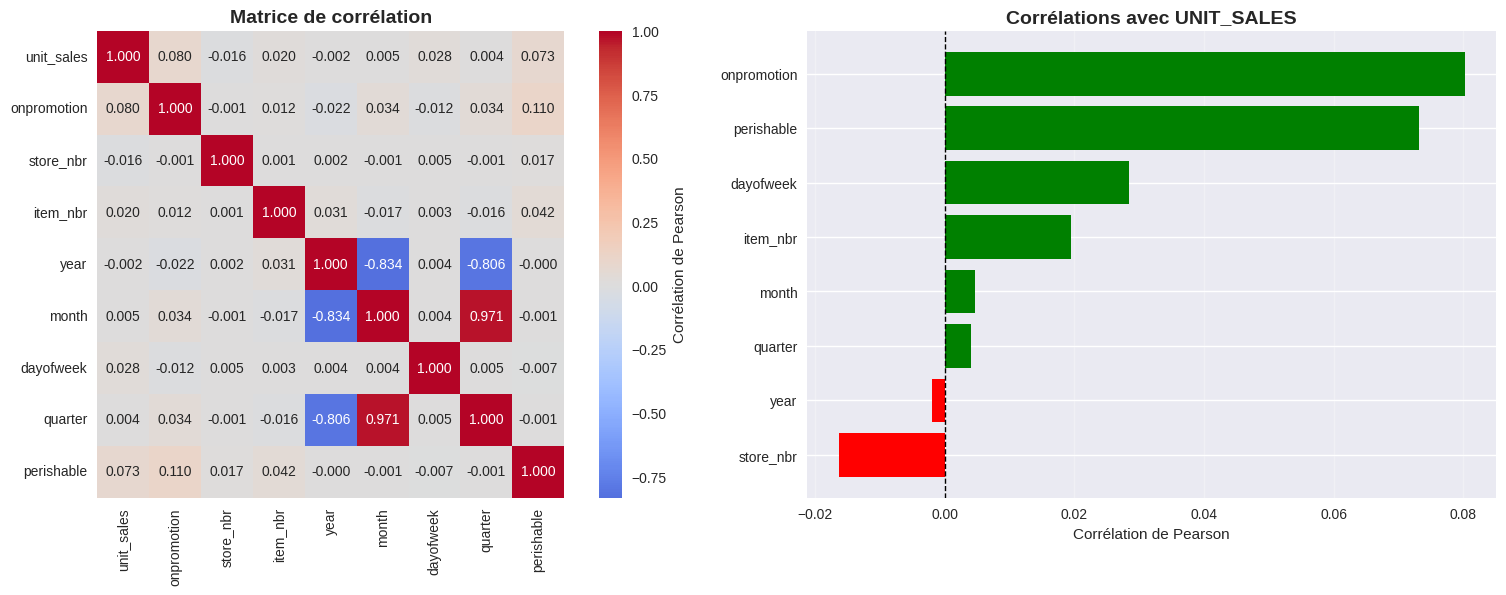

In [17]:
# Visualisation corrélations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, ax=axes[0], 
            cbar_kws={'label': 'Corrélation de Pearson'})
axes[0].set_title('Matrice de corrélation', fontsize=14, fontweight='bold')

# Barplot corrélations avec cible
target_corr_sorted = target_corr[1:].sort_values()
colors_bar = ['red' if x < 0 else 'green' for x in target_corr_sorted.values]
axes[1].barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors_bar)
axes[1].set_yticks(range(len(target_corr_sorted)))
axes[1].set_yticklabels(target_corr_sorted.index)
axes[1].set_title('Corrélations avec UNIT_SALES', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Corrélation de Pearson')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('outputs/02_multivariate_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. ANALYSE PAR FAMILLE DE PRODUITS

TOP 10 FAMILLES DE PRODUITS (par volume)
                        sum       mean    count
family                                         
GROCERY I      1.616596e+07   6.556702  2465563
BEVERAGES      1.251678e+07  11.238223  1113769
PRODUCE        8.380820e+06  17.134661   489115
CLEANING       4.278989e+06   5.156427   829836
DAIRY          3.343883e+06   6.647786   503007
BREAD/BAKERY   1.838512e+06   8.118771   226452
POULTRY        1.502663e+06  18.177082    82668
DELI           1.200209e+06   5.806304   206708
PERSONAL CARE  1.112122e+06   4.295665   258894
MEATS          1.106419e+06  11.558064    95727


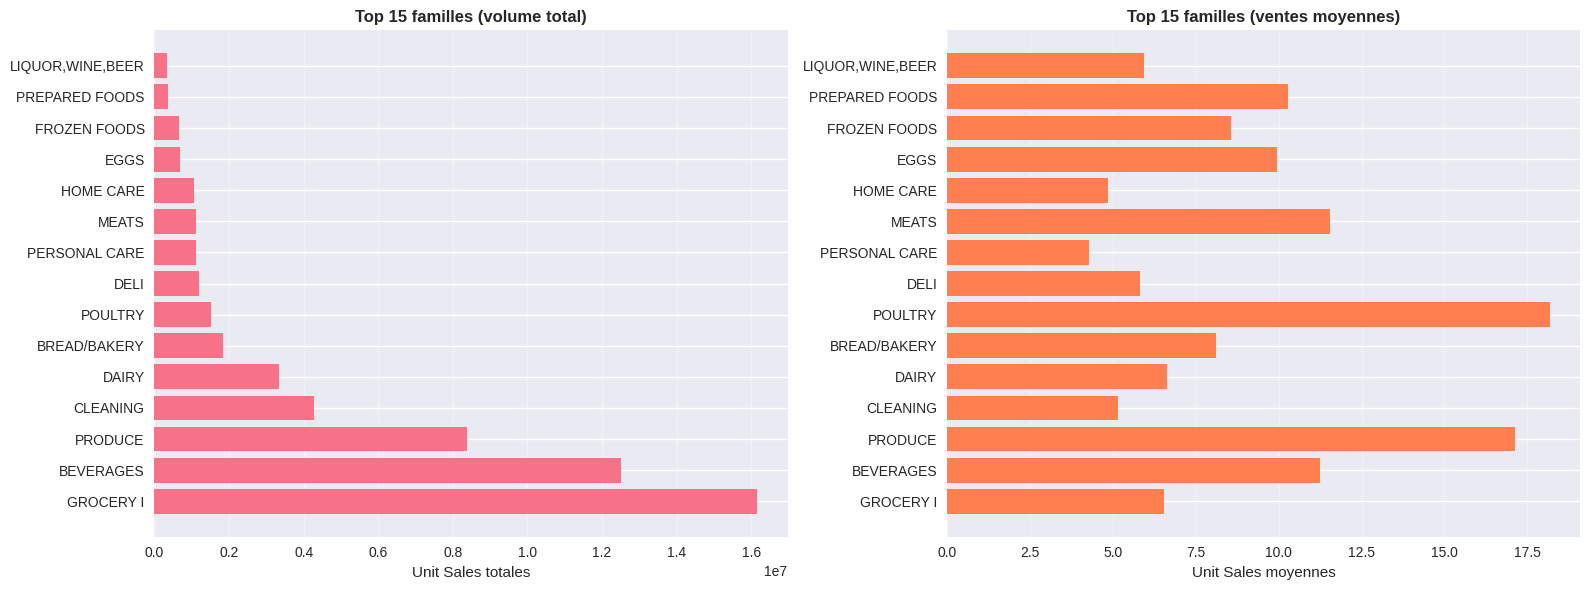

In [18]:
# Top familles par volume
family_sales = train.groupby('family')['unit_sales'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)

print("=" * 60)
print("TOP 10 FAMILLES DE PRODUITS (par volume)")
print("=" * 60)
print(family_sales.head(10))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 familles
top15 = family_sales.head(15)
axes[0].barh(range(len(top15)), top15['sum'].values)
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15.index)
axes[0].set_title('Top 15 familles (volume total)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Unit Sales totales')
axes[0].grid(alpha=0.3, axis='x')

# Ventes moyennes par famille
axes[1].barh(range(len(top15)), top15['mean'].values, color='coral')
axes[1].set_yticks(range(len(top15)))
axes[1].set_yticklabels(top15.index)
axes[1].set_title('Top 15 familles (ventes moyennes)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Unit Sales moyennes')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('outputs/02_family_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. SYNTHÈSE DE L'ANALYSE

In [19]:
print("=" * 70)
print("SYNTHÈSE DE L'ANALYSE STATISTIQUE")
print("=" * 70)

print("\n1. VARIABLE CIBLE (UNIT_SALES)")
print(f"   Moyenne    : {train['unit_sales'].mean():.2f}")
print(f"   Médiane    : {train['unit_sales'].median():.2f}")
print(f"   Écart-type : {train['unit_sales'].std():.2f}")
print(f"   Positives  : {len(sales_pos):,} ({len(sales_pos)/len(train)*100:.2f}%)")
print(f"   Négatives  : {len(sales_neg):,} (retours produits)")

print("\n2. IMPACT DES PROMOTIONS")
if len(sales_no_promo) > 0 and len(sales_with_promo) > 0:
    print(f"   Sans promo : {sales_no_promo.mean():.2f} ventes moyennes")
    print(f"   Avec promo : {sales_with_promo.mean():.2f} ventes moyennes")
    increase = (sales_with_promo.mean() - sales_no_promo.mean()) / sales_no_promo.mean() * 100
    print(f"   Augmentation : +{increase:.1f}% avec promotions")

print("\n3. GRANULARITÉ DES DONNÉES")
print(f"   Magasins      : {train['store_nbr'].nunique()}")
print(f"   Items         : {train['item_nbr'].nunique()}")
print(f"   Familles      : {train['family'].nunique()}")
print(f"   Combinaisons  : {train[['store_nbr','item_nbr']].drop_duplicates().shape[0]:,} (store, item)")

print("\n4. CORRÉLATIONS PRINCIPALES (avec unit_sales)")
for feat, corr_val in target_corr[1:4].items():
    print(f"   {feat:15s} : {corr_val:+.4f}")

print("\n5. TEMPORALITÉ")
print(f"   Période    : {train['date'].min().date()} à {train['date'].max().date()}")
print(f"   Nb jours   : {train['date'].nunique()}")
print(f"   Meilleur jour semaine : {jours[weekday.idxmax()]} ({weekday.max():.2f} ventes moy.)")
print(f"   Pire jour semaine     : {jours[weekday.idxmin()]} ({weekday.min():.2f} ventes moy.)")

print("\n" + "=" * 70)

SYNTHÈSE DE L'ANALYSE STATISTIQUE

1. VARIABLE CIBLE (UNIT_SALES)
   Moyenne    : 7.92
   Médiane    : 4.00
   Écart-type : 22.25
   Positives  : 6,980,448 (99.99%)
   Négatives  : 435 (retours produits)

2. IMPACT DES PROMOTIONS
   Sans promo : 7.25 ventes moyennes
   Avec promo : 12.70 ventes moyennes
   Augmentation : +75.1% avec promotions

3. GRANULARITÉ DES DONNÉES
   Magasins      : 10
   Items         : 4016
   Familles      : 33
   Combinaisons  : 30,757 (store, item)

4. CORRÉLATIONS PRINCIPALES (avec unit_sales)
   onpromotion     : +0.0802
   perishable      : +0.0732
   dayofweek       : +0.0284

5. TEMPORALITÉ
   Période    : 2016-08-15 à 2017-08-15
   Nb jours   : 364
   Meilleur jour semaine : Dim (9.57 ventes moy.)
   Pire jour semaine     : Jeu (6.61 ventes moy.)



In [20]:
# Sauvegarder insights pour notebooks suivants
import json

insights = {
    'unit_sales_mean': float(train['unit_sales'].mean()),
    'unit_sales_median': float(train['unit_sales'].median()),
    'unit_sales_std': float(train['unit_sales'].std()),
    'n_positives': int(len(sales_pos)),
    'n_negatives': int(len(sales_neg)),
    'n_stores': int(train['store_nbr'].nunique()),
    'n_items': int(train['item_nbr'].nunique()),
    'n_families': int(train['family'].nunique()),
    'promo_impact_pct': float(increase) if len(sales_no_promo) > 0 and len(sales_with_promo) > 0 else None,
    'top_correlations': {k: float(v) for k, v in target_corr[1:4].items()},
    'date_min': str(train['date'].min().date()),
    'date_max': str(train['date'].max().date())
}

with open('outputs/02_analysis_insights.json', 'w') as f:
    json.dump(insights, f, indent=4)

print("Insights sauvegardés dans outputs/02_analysis_insights.json")

Insights sauvegardés dans outputs/02_analysis_insights.json
